# Libraries

In [149]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [150]:
articles = []

dir = "data/top5/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title

        # Set URL and filter URL (Bob Dylan's case)
        url = data[0]["url"]
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue

        # Set entities and filter by number
        entities = data[0]["story_tags"]
        if len(entities) > 100:
            continue  # Filter max
        if len(entities) <= 1:
            continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            # print('name', name)
            # Remove brackets with text
            cleaned = re.sub(r"\([^()]*\)", "", name)
            name = cleaned
            name = " ".join(name.split())  # Merge multiple spaces
            name = name.lstrip()  # Remove leading whitespaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            # print('name', name)

            if name in {"World Health Organisation"}:
                continue  # Stopwords

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            )  # Add these articles with actors only

    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(
    subset=["url"]
)  # Remove articles with the same URL

print("The number of articles is " + str(articles.shape[0]))

articles.sample(1)


The number of articles is 2744


,year,title,url,subjects,orgs,people
596,2022,The climate bill won’t stop global warming. Bu...,https://www.washingtonpost.com/climate-environ...,"[global warming, energy and power, weather, ai...","[Princeton, Senate, Department of Energy, Amer...","[Rob Jackson, Leah Stokes, John Barrasso, Joe ..."


## Entities

In [151]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 15903


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
29,energy and power,subject,1218,NaN,None,-1,-1,-1,"{2012: 6, 2013: 52, 2014: 49, 2015: 38, 2016: ...",[http://www.marketwatch.com/news/story.asp?gui...,[Outside the Box: Republicans should embrace t...,"[Energy Information Administration, internatio..."


# Treatment

## Normalization

In [152]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
6493,Simon Carr,person,1,NaN,None,-1,-1,-1,"{2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, ...",[https://www.nytimes.com/2021/08/26/business/a...,[A New Coal Mine for England Is Stirring Hopes...,"[Barry Patrickson, University of Central Lanca...",0.0,"{""2012"": 0, ""2013"": 0, ""2014"": 0, ""2015"": 0, ""..."


## Filter

In [153]:
n = 50  # Number of rows by type

top_subjects = (
    entities_all.loc[entities_all["type"] == "subject"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n * 3)
)
top_orgs = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n)
)
top_people = (
    entities_all.loc[entities_all["type"] == "person"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n)
)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
547,suits and litigation,subject,37,NaN,None,-1,-1,-1,"{2012: 1, 2013: 0, 2014: 1, 2015: 1, 2016: 1, ...",[https://www.washingtonpost.com/business/energ...,[Why Delaware Is Where Musk and Twitter Will F...,"[Delaware Chancery Court, University of Pennsy...",0.029581,"{""2012"": 1, ""2013"": 0, ""2014"": 1, ""2015"": 1, ""..."


## Linear Regression

In [154]:
# For each

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, "slope"] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities["type"] == "subject"]
average_subjects = entities_subjects["slope"].mean() / 2
for i, row in entities_subjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities["type"] != "subject"]
average_nosubjects = entities_nosubjects["slope"].mean() / 2
for i, row in entities_nosubjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
51,Pete Buttigieg,person,30,-0.385682,None,-1,-1,-1,"{2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, ...",[https://nypost.com/2022/07/28/manchin-schumer...,[Manchin-Schumer deal smaller than Build Back ...,"[Transportation, Senate, Chuck Schumer, Nancy ...",0.023829,"{""2012"": 0, ""2013"": 0, ""2014"": 0, ""2015"": 0, ""..."


## Colors

In [155]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
29,energy and power,subject,1218,27.048152,#cccccc,-1,-1,-1,"{2012: 6, 2013: 52, 2014: 49, 2015: 38, 2016: ...",[http://www.marketwatch.com/news/story.asp?gui...,[Outside the Box: Republicans should embrace t...,"[Energy Information Administration, internatio...",1.0,"{""2012"": 6, ""2013"": 52, ""2014"": 49, ""2015"": 38..."


# Embedding

## Term Frequency

In [156]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


## UMAP

In [167]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=3,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3896,news and news media,subject,6,-0.988212,#cccccc,459,246,-1,"{2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 2, ...",[https://www.washingtonpost.com/opinions/2021/...,[Humanity faces a climate emergency — shouldn’...,"[Congress, global warming, Laura Helmuth, Colu...",0.004108,"{""2012"": 0, ""2013"": 0, ""2014"": 0, ""2015"": 0, ""..."


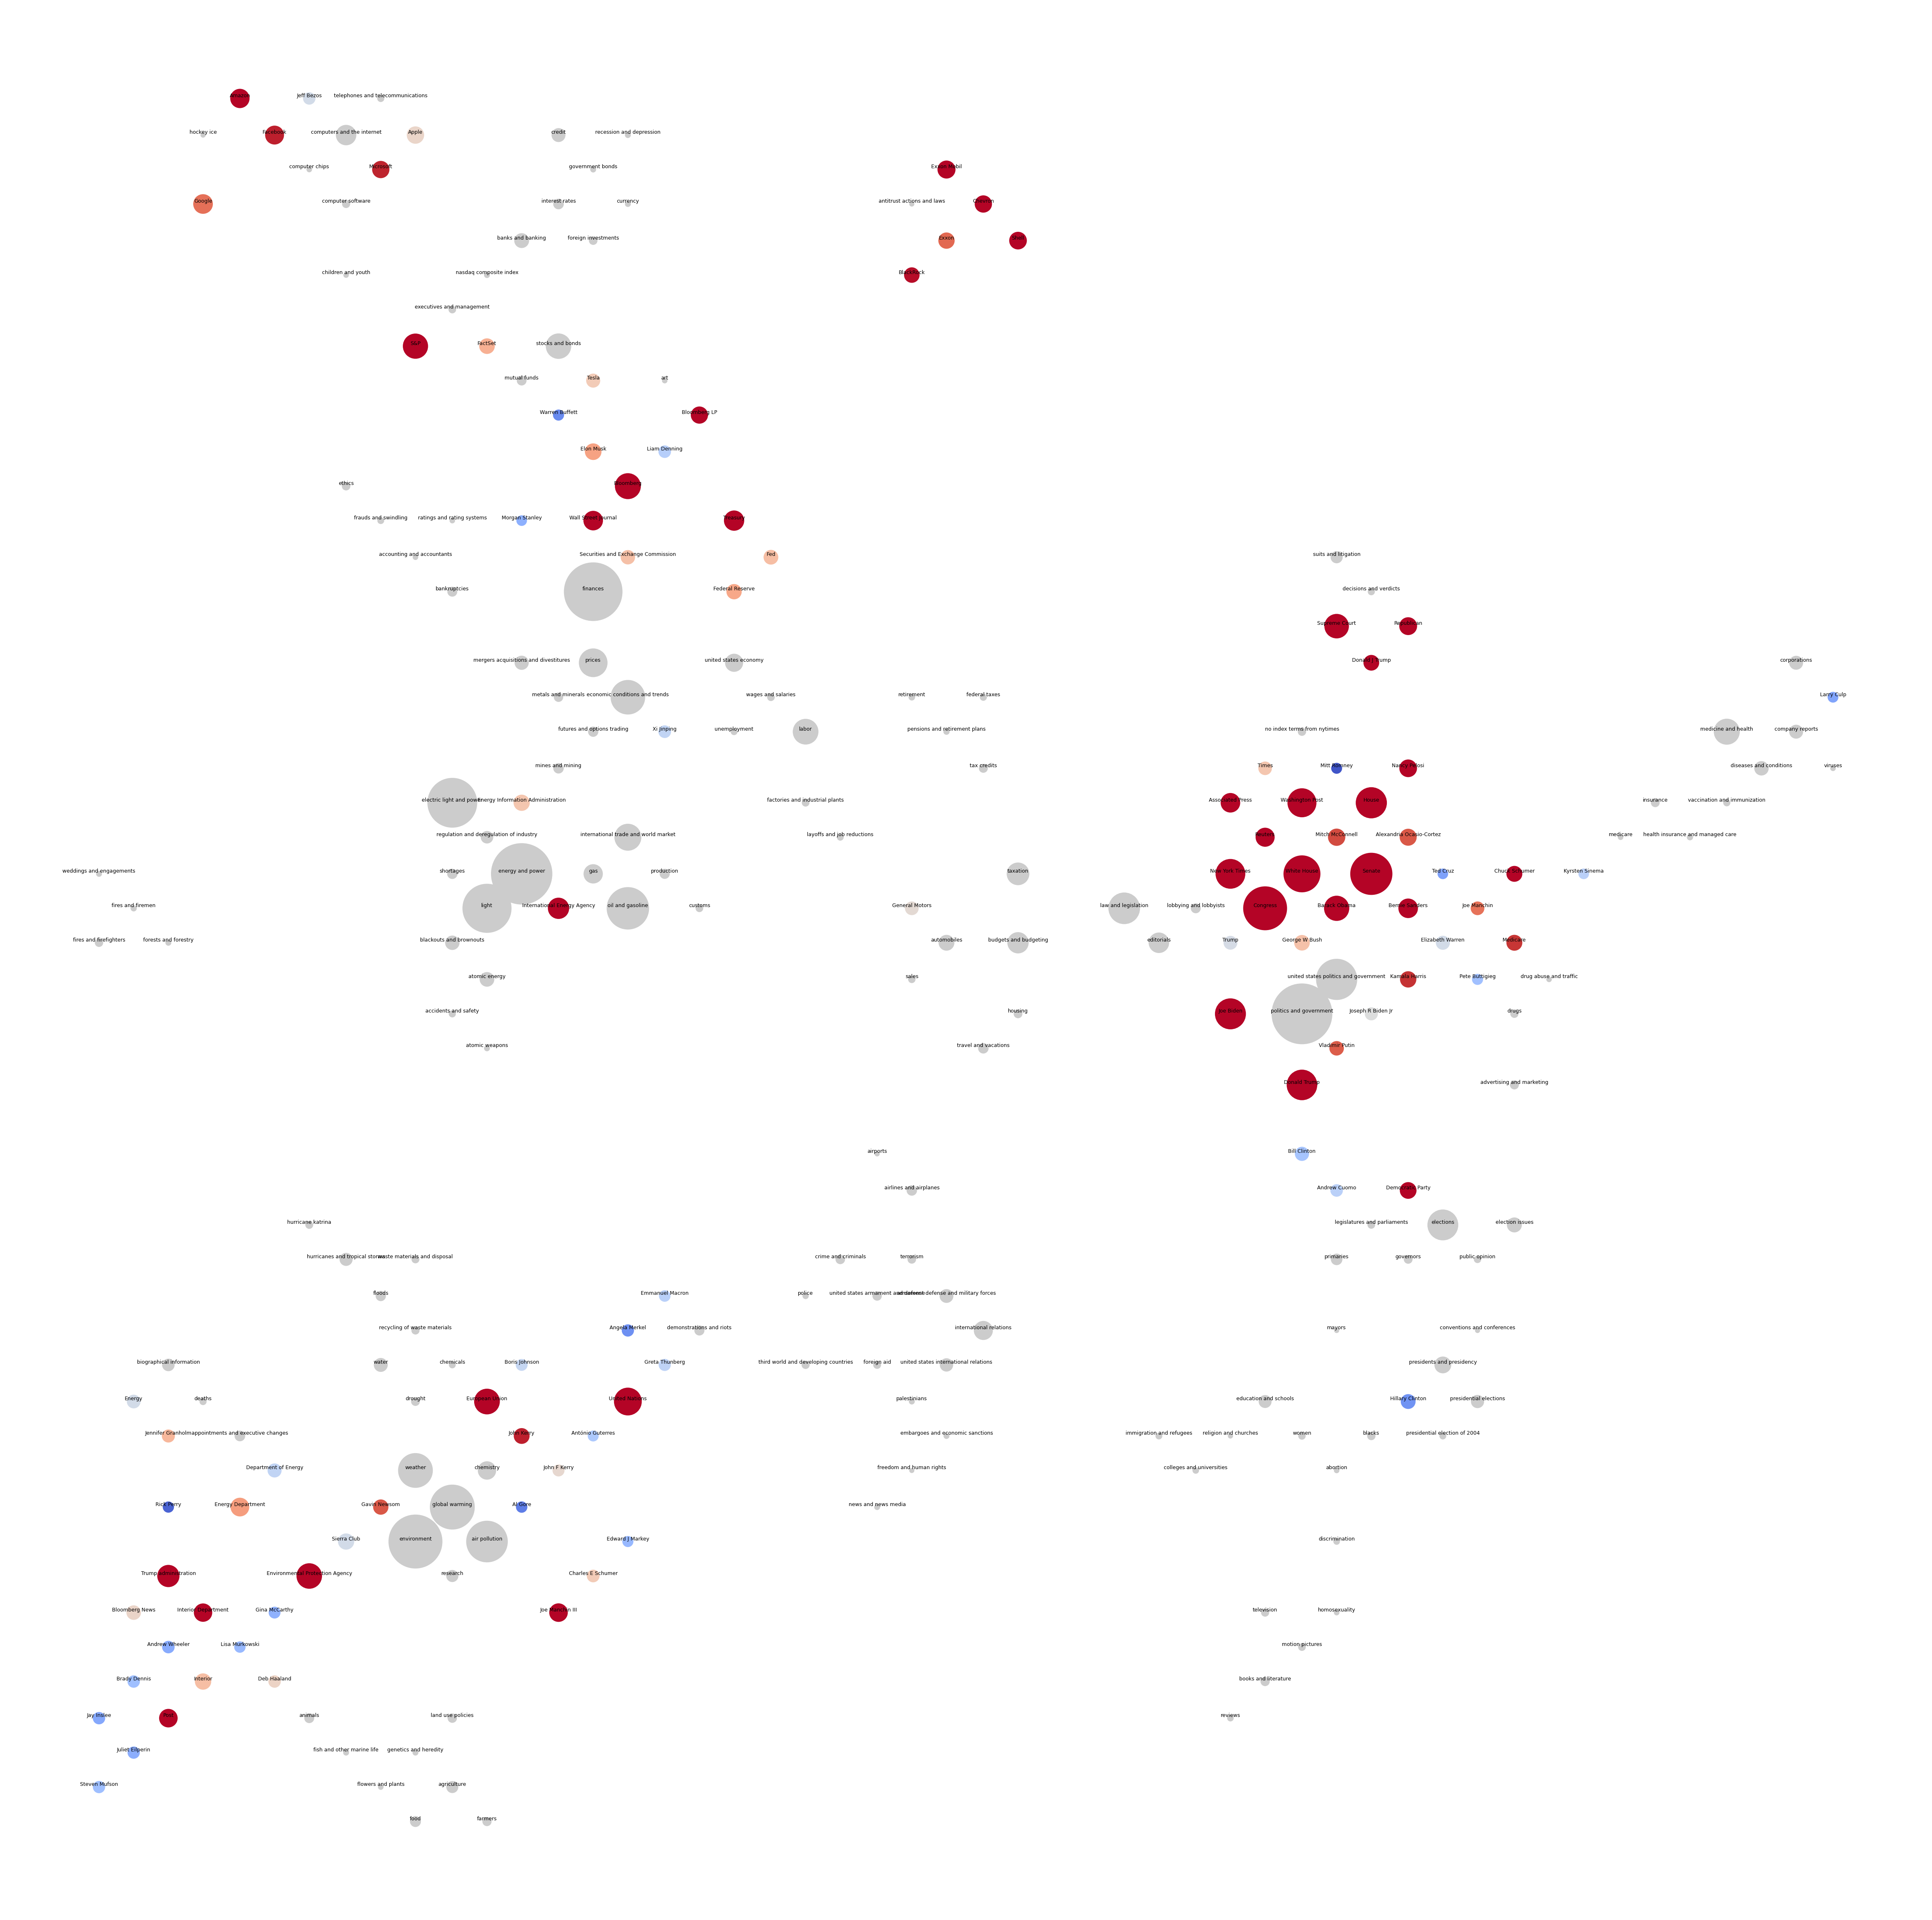

In [168]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [169]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
404,governors,subject,17,-0.824576,#cccccc,704,361,-1,"{2012: 1, 2013: 3, 2014: 0, 2015: 0, 2016: 0, ...",[http://articles.washingtonpost.com/2012-11-07...,[Republicans broaden hold on governors&rsquo; ...,"[Brian Schweitzer, Rob McKenna, Senate, Beverl...",0.013147,"{""2012"": 1, ""2013"": 3, ""2014"": 0, ""2015"": 0, ""..."


{'p_1', 'p_3', 'n_2', 'p_2', 'p_0', 'n_1', '-1', 'n_0', 'p_4'}
27
6
18
5
16
5
152
11
10


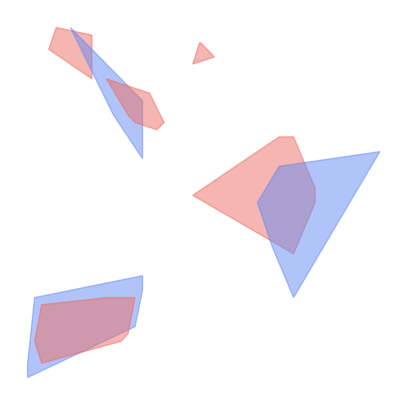

In [170]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [171]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
375,Trump,org,50,-0.058409,#d5dbe5,622,508,n_0,[https://www.washingtonpost.com/world/middle_e...,0.040263,"{""2012"": 0, ""2013"": 0, ""2014"": 0, ""2015"": 0, ""..."
